In [1]:
import yahoo_fin.stock_info as si
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import set_theme, heatmap

from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import R2Score
from keras.utils import plot_model

import warnings
warnings.filterwarnings("ignore")

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [36]:
# Get live price data 
live_price = si.get_live_price('GOOG')
print('The current price is: ', live_price)

# Save live price to CSV
live_price_df = pd.DataFrame({'Timestamp': [datetime.now()], 'Price': [live_price]})
# live_price_df.to_csv('live_price.csv', index=False)

# Get historical data for a specific stock symbol (e.g., 'AAPL')
start_date = '2016-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

df_updated = si.get_data('GOOG', start_date=start_date, end_date=end_date)

# Save historical data to CSV
df_updated.to_csv('../Datasets/Project2_RNN/Google_updated.csv')

# Print the historical data
df_updated

The current price is:  188.360107421875


,open,high,low,close,adjclose,volume,ticker
2016-01-04,37.150002,37.202999,36.562901,37.091999,36.959202,65456000,GOOG
2016-01-05,37.322498,37.599998,36.931999,37.129002,36.996071,39014000,GOOG
2016-01-06,36.500000,37.359001,36.445999,37.181000,37.047878,38940000,GOOG
2016-01-07,36.515499,36.924999,35.952999,36.319500,36.189465,59274000,GOOG
2016-01-08,36.572498,36.661499,35.650002,35.723499,35.595604,49018000,GOOG
...,...,...,...,...,...,...,...
2025-02-03,202.214996,205.220001,201.660004,202.639999,202.639999,16719500,GOOG
2025-02-04,204.500000,208.699997,204.259995,207.710007,207.710007,28285400,GOOG
2025-02-05,193.100006,194.550003,189.910004,193.300003,193.300003,43666400,GOOG
2025-02-06,190.990005,193.830002,190.490005,193.309998,193.309998,20816600,GOOG


In [37]:
df.tail(1)

,open,high,low,close,volume,Open,High,Low,Close,Volume
date,,,,,,,,,,
2024-05-24,176.520004,177.304001,175.199997,176.330002,11400600,0.968911,0.963836,0.970726,0.956066,-0.925606


In [39]:
df_updated.loc[df.tail(1).index]

,open,high,low,close,adjclose,volume,ticker
date,,,,,,,
2024-05-24,176.520004,177.304001,175.199997,176.330002,175.6987,11400600,GOOG


In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

df = pd.read_csv('../Datasets/Project2_RNN/Google.csv')

# Rename column and convert to datetime
df.rename(columns={'Unnamed: 0':'date'},inplace=True)
df['date'] = pd.to_datetime(df['date'])

# Check missing values
print(df.isnull().sum())

# Check duplicate and constant value columns
if df['ticker'].unique():
    print(f"\nticker is constant value {df['ticker'].unique()}")
    df.drop(columns=['ticker'],inplace=True)
    
if (df['close'] == df['adjclose']).unique():
    print(f"\nadjclose and close are the same: {(df['close'] == df['adjclose']).unique()}\n") 
    df.drop(columns=['adjclose'],inplace=True)

# # Adding Timeseries features
# df.insert(0,'day',df['date'].dt.day)
# df.insert(0,'month',df['date'].dt.month)
# df.insert(0,'year',df['date'].dt.year)

df.set_index(['date'],inplace=True)

# Apply scaling to each column individually
df['Open'] = scaler.fit_transform(df.open.values.reshape(-1, 1))
df['High'] = scaler.fit_transform(df.high.values.reshape(-1, 1))
df['Low'] = scaler.fit_transform(df.low.values.reshape(-1, 1))
df['Close'] = scaler.fit_transform(df.close.values.reshape(-1, 1))
df['Volume'] = scaler.fit_transform(df.volume.values.reshape(-1, 1))

df1 = df[['Volume', 'Open', 'High', 'Low', 'Close']]

df1

date        0
open        0
high        0
low         0
close       0
adjclose    0
volume      0
ticker      0
dtype: int64

ticker is constant value ['GOOG']

adjclose and close are the same: [ True]



,Volume,Open,High,Low,Close
date,,,,,
2016-01-04,-0.024878,-0.948311,-0.950962,-0.952692,-0.949647
2016-01-05,-0.465482,-0.945938,-0.945536,-0.947571,-0.949140
2016-01-06,-0.466716,-0.957252,-0.948830,-0.954314,-0.948428
2016-01-07,-0.127889,-0.957039,-0.954761,-0.961153,-0.960220
2016-01-08,-0.298785,-0.956255,-0.958363,-0.965357,-0.968377
...,...,...,...,...,...
2024-05-20,-0.824053,0.979778,1.000000,0.998821,0.985219
2024-05-21,-0.870528,0.994773,0.998223,1.000000,1.000000
2024-05-22,-0.845810,0.994773,0.984993,0.992647,0.978923


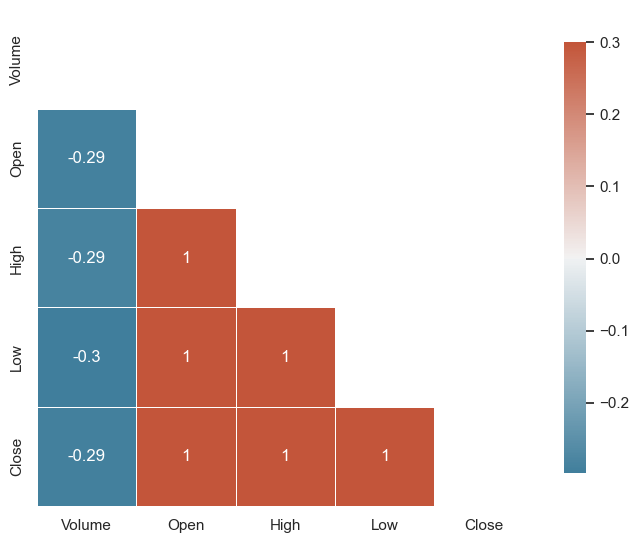

In [35]:
set_theme(style="white")

# Compute the correlation matrix
corr = df1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

plt.show()

## Training Machine Learning

In [5]:
# ---------------------- Step 1: Prepare Data ----------------------

# Function to create time-series input for LSTM
def df_to_X_y(df, window_size):
    df_as_np = np.array(df)  # Convert DataFrame to NumPy array
    X, y = [], []

    for i in range(window_size, len(df_as_np)):
        stack = []
        for j in range(i-window_size,i):
            features = df_as_np[j+1, :-1]  # Extract feature values only from the current row (excluding target column)
            past_targets = df_as_np[j, -1]  # Last column (target) from previous rows
            stack.append(np.hstack([features, past_targets]))
        
        # Combine features and past targets into X
        X.append(stack)  # Concatenate feature values & past targets

        # Store the target of the current row
        y.append(df_as_np[i, -1])  # Target value of current row

    return np.array(X), np.array(y)

WINDOW_SIZE = 90  # Define time steps for LSTM

# Function to split dataset into train, validation, and test sets
def split_train_test(df):
    X, y = df_to_X_y(df, WINDOW_SIZE)

    # Define train, validation, and test split sizes
    train_size = int(len(df) * 0.98)
    test_size = 100
    val_size = len(df) - train_size - test_size

    # Split the dataset accordingly
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[-test_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[-test_size:]

    return X_train, X_val, X_test, y_train, y_val, y_test

# Ensure df is defined before calling the function

X_train, X_val, X_test, y_train, y_val, y_test = split_train_test(df)

# Check shapes
print("Train Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)

# Check the first row of X_test
print("\nX_test[9]:\n", X_test[len(X_test)-1])  # Should contain feature values + 5 past target values
print("\ny_test[9]:", y_test[len(X_test)-1])  # Should match y[-10]

df.tail(WINDOW_SIZE)

Train Set: (2023, 90, 5) (2023,)
Validation Set: (0, 90, 5) (0,)
Test Set: (100, 90, 5) (100,)

X_test[9]:
 [[-0.80102978  0.51385096  0.53032437  0.52884713  0.49838161]
 [-0.66282472  0.55326274  0.56387734  0.56283781  0.52712382]
 [-0.75183377  0.58634693  0.59087028  0.58753309  0.5679102 ]
 [-0.88039925  0.57272808  0.5750846   0.58212233  0.56435173]
 [-0.79489444  0.60808177  0.612123    0.61888772  0.57762766]
 [-0.7574009   0.62802863  0.65572142  0.63803358  0.60048467]
 [-0.79073701  0.64357315  0.64683777  0.65995415  0.64551391]
 [-0.76716211  0.65416559  0.66173505  0.66161893  0.64756683]
 [-0.67268925  0.65925537  0.65954824  0.65960718  0.66193793]
 [-0.38392348  0.54067578  0.53039257  0.50387432  0.63743879]
 [-0.69021879  0.51729004  0.5171353   0.51372457  0.48346313]
 [-0.41377868  0.47877224  0.50702165  0.45698093  0.4959181 ]
 [-0.62810724  0.52210463  0.54515325  0.53661641  0.5072779 ]
 [-0.75702431  0.54851699  0.54611006  0.54507941  0.52630244]
 [-0.75838

,volume,open,high,low,close
date,,,,,
2024-01-18,-0.801030,0.513851,0.530324,0.528847,0.527124
2024-01-19,-0.662825,0.553263,0.563877,0.562838,0.567910
2024-01-22,-0.751834,0.586347,0.590870,0.587533,0.564352
2024-01-23,-0.880399,0.572728,0.575085,0.582122,0.577628
2024-01-24,-0.794894,0.608082,0.612123,0.618888,0.600485
...,...,...,...,...,...
2024-05-20,-0.824053,0.979778,1.000000,0.998821,0.985219
2024-05-21,-0.870528,0.994773,0.998223,1.000000,1.000000
2024-05-22,-0.845810,0.994773,0.984993,0.992647,0.978923


Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0587
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0050
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0023
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0022
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0020
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0019
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0017
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0016
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0016
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0016
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0014
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0015
Epoch 13/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0013
Epoch 14/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0013
Epoch 15/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - lo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 90, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │             825 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,563 (365.48 KB)

 Trainable params: 31,187 (121.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,376 (243.66 KB)

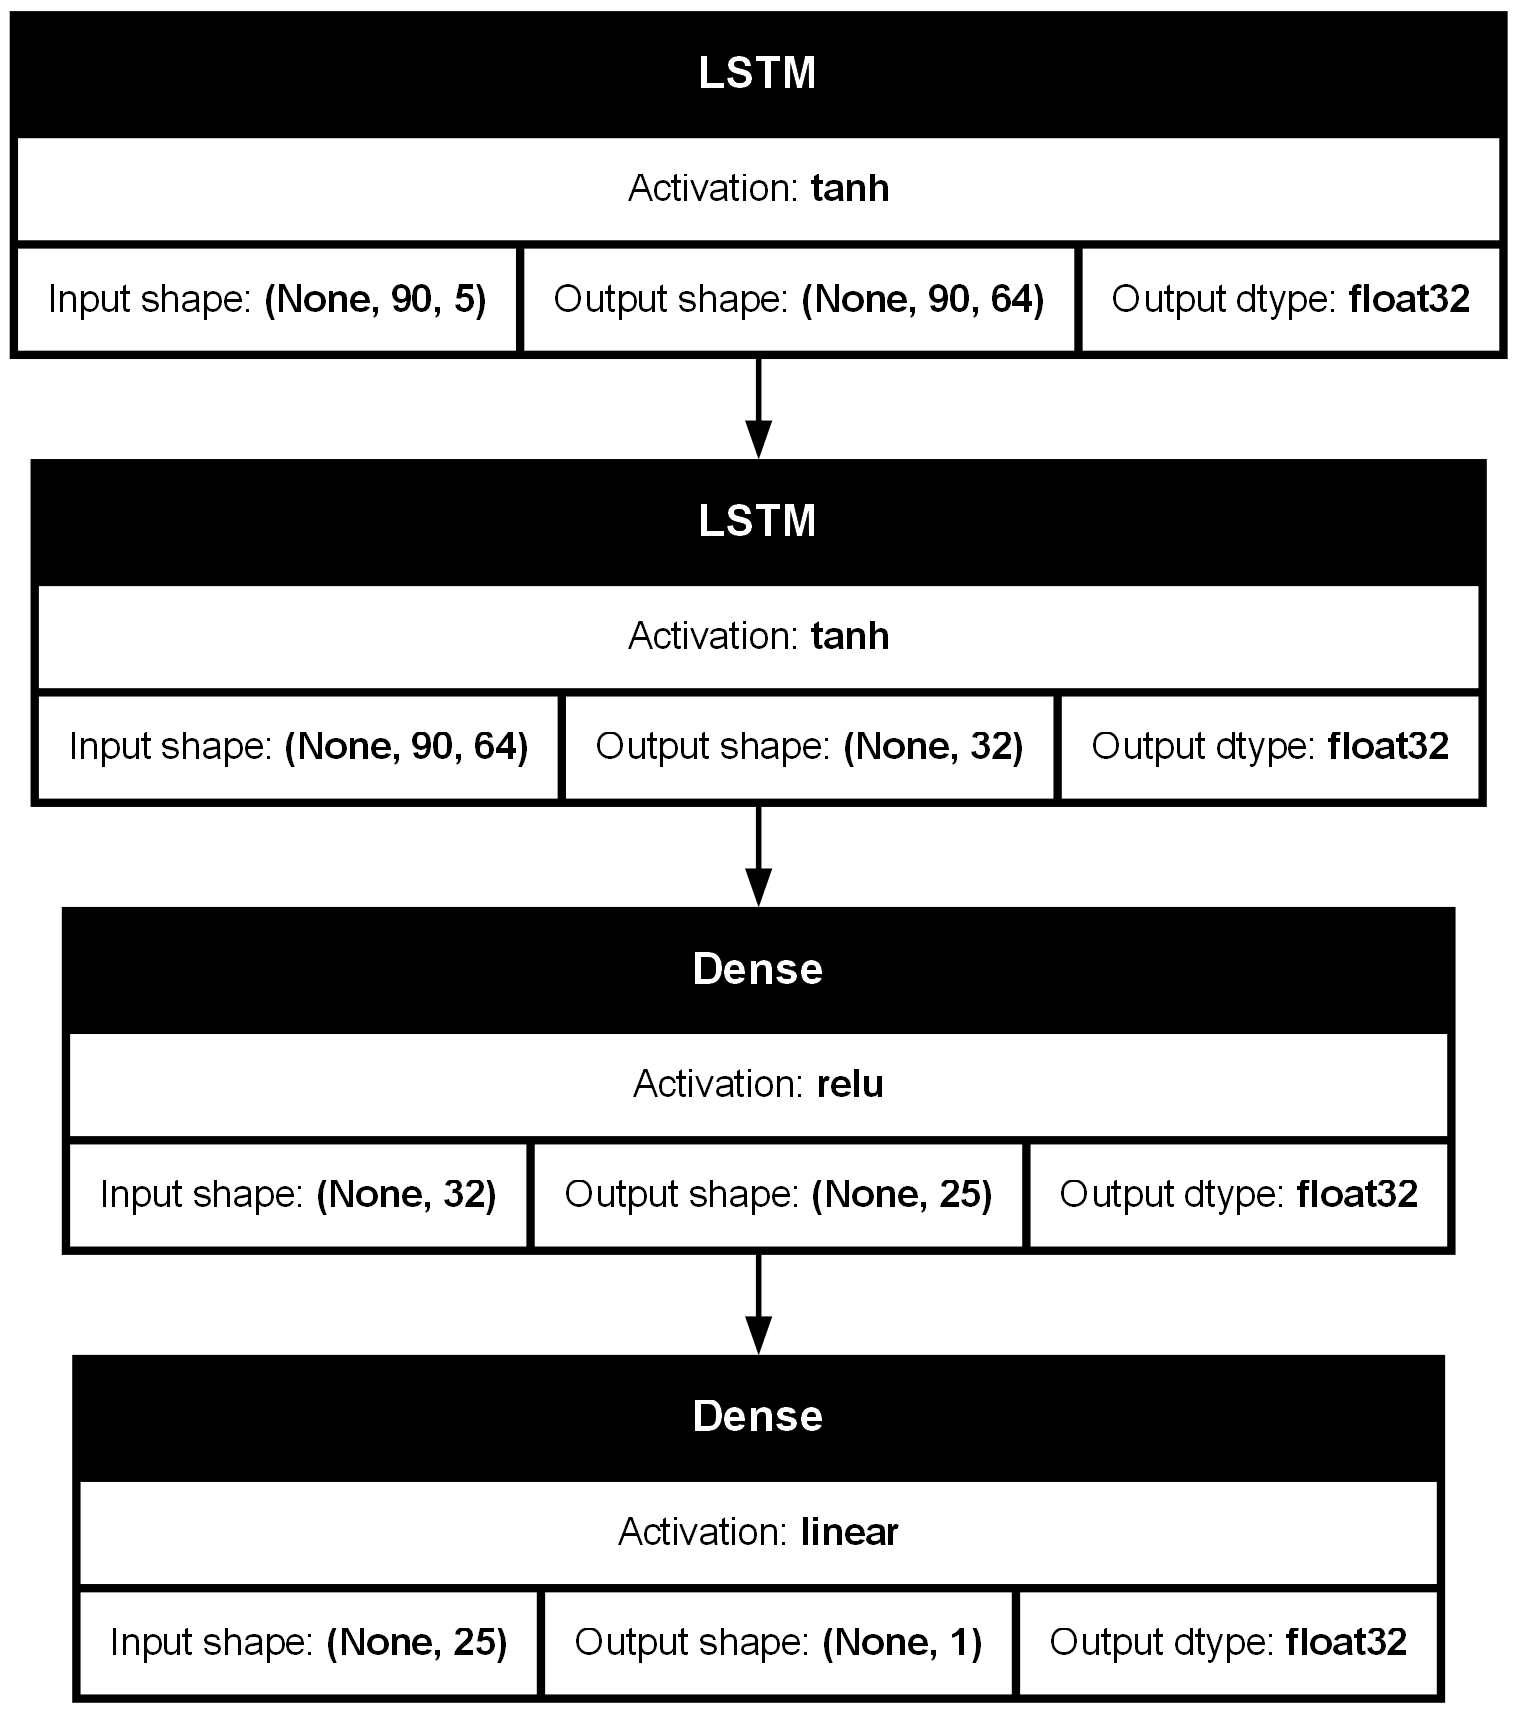

In [6]:
# ---------------------- Step 2: Define Model ----------------------

# Initialize LSTM Model
model = Sequential()
model.add(LSTM(units= 64, return_sequences=True))  # LSTM layer with 64 units
model.add(LSTM(units= 32, return_sequences=False))  # LSTM layer with 32 units

model.add(Dense(units=25, activation='relu'))  # Fully connected layer
model.add(Dense(units=1,  activation='linear'))  # Output layer for regression

# ---------------------- Step 3: Compile Model ----------------------

model.compile(optimizer='adam', loss='mean_squared_error')


# ---------------------- Step 4: Train Model ----------------------

num_epochs = 200

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=num_epochs,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# ---------------------- Step 5: Visualize Model ----------------------
model.summary()  # Display model architecture
plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step


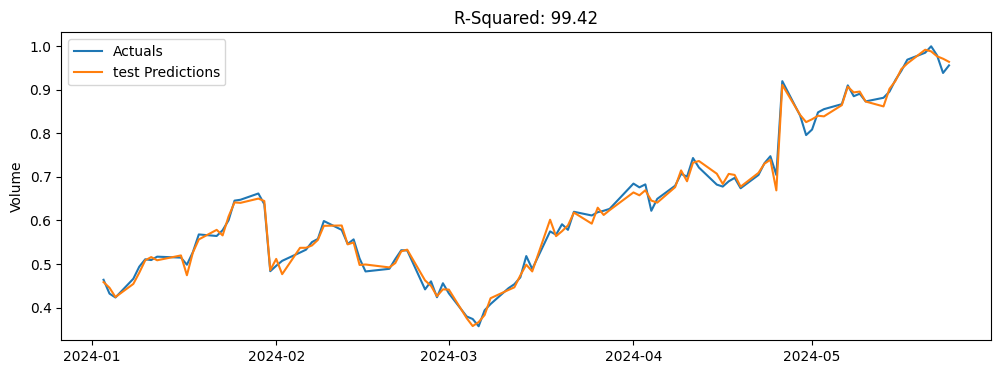

In [7]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'test Predictions':test_predictions, 'Actuals':y_test})

R2 = np.round(100*r2_score(test_results['Actuals'],test_results['test Predictions']),2)

plt.figure(figsize=(12,4))
plt.title(f'R-Squared: {R2}')
plt.plot(df.index[-len(X_test):],test_results['Actuals'],label='Actuals')
plt.plot(df.index[-len(X_test):],test_results['test Predictions'],label='test Predictions')
d1 = df.index[-len(X_test)]
d2 = df.index[-1]
# plt.xlabel(f'from {d1.strftime("%Y-%m-%d")}  to  {d2.strftime("%Y-%m-%d")}')
plt.ylabel('Volume')
plt.legend()
plt.show()